# Notebook for feature extraction from the MOVIES

The features that we want to extract are:
- brightness
- contrast
- saturation
- sound strength
- music presence

The features are extracted from the movies using the following methods:
- **brightness**:
    1. Divide the video in frames using: https://www.geeksforgeeks.org/python-program-extract-frames-using-opencv/
    2. Convert the image to HSV color space (the Value channel is an approximation for brightness)
    3. Sum up all the values of the pixels in the Value channel
    4. Divide that brightness sum by the area of the image, which is just the width times the height.
    5. This gave us one value: the average brightness of that image per each time stamp.
- **contrast**:
    1. Same as brightness just with contrast
- **saturation**:
    1. Same as brightness just with saturation
- **sound strength**:
    1. Follow: https://towardsdatascience.com/generate-any-sport-highlights-using-python-3695c98baead

In [2]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

### **BRIGHTNESS**

1. Divide the video in frames using: https://www.geeksforgeeks.org/python-program-extract-frames-using-opencv/
2. Convert the image to HSV color space (the Value channel is an approximation for brightness)
3. Sum up all the values of the pixels in the Value channel
4. Divide that brightness sum by the area of the image, which is just the width times the height.
5. This gave us one value: the average brightness of that image per each time stamp.

In [4]:
PATH_MOVIES = '/Users/silviaromanato/Desktop/ServerMIPLAB/FilmFiles/'

for movie_name in os.listdir(PATH_MOVIES):
    MOVIE_PATH = PATH_MOVIES + movie_name
    break
MOVIE_PATH

OSError: [Errno 6] Device not configured: '/Users/silviaromanato/Desktop/ServerMIPLAB/FilmFiles/'

Extracting the frames from the first movie:

In [23]:
def convert_to_hsv(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv_image)
    return h, s, v

average_brightness = []
average_saturation = []
def FrameCapture(MOVIE_PATH):
    # Path to video file
    vidObj = cv2.VideoCapture(MOVIE_PATH)

    count = 0
    success = 1

    while success:
        success, image = vidObj.read()
        count += 1
        h_channel, s_channel, v_channel = convert_to_hsv(image)        
        sum_v = np.sum(v_channel)
        sum_s = np.sum(s_channel)
        height, width = v_channel.shape[:2]
        total_pixels = width * height
        average_brightness.append(sum_v / total_pixels)
        average_saturation.append(sum_s / total_pixels)


FrameCapture(MOVIE_PATH)

print(average_brightness)
print(average_saturation)

### **SOUND STRENGTH**:
Follow: https://towardsdatascience.com/generate-any-sport-highlights-using-python-3695c98baead

In [ ]:
!pip install moviepy

1. Extract the audio from the movie

In [ ]:
import moviepy.editor as mp
clip = mp.VideoFileClip(MOVIE_PATH).subclip(1, 1380)
clip.audio.write_audiofile("/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Audio/audioYouAgain.wav")

2. Create chunks from the audio

In [ ]:
import librosa
import IPython.display as ipd

filename = "filepath\\audio.wav"
# loading the file with a sampling rate
x, sr = librosa.load(filename, sr=22050)
# To get duration of the audio clip in minutes
int(librosa.get_duration(x, sr) / 60)
max_slice = 10
window_length = max_slice * sr
# Playing the audio chunk
a = x[21 * window_length:22 * window_length]
ipd.Audio(a, rate=sr)

3. Compute the short time energy of the chunk <br> <br>

The energy or power of an audio signal refers to the loudness of the sound. It is computed by the sum of the square of the amplitude of an audio signal in the time domain. When energy is computed for a chunk of an entire audio signal, then it is known as Short Time Energy.

In [ ]:
import numpy as np
s_energy = np.array([sum(abs(x[i:i + window_length] ** 2)) for i in range(0, len(x), window_length)])


import matplotlib.pyplot as plt
plt.hist(s_energy)
plt.show()

## **LOAD THE DATA EXTRACTED**

In [286]:
#df = pd.read_csv('/Users/silviaromanato/Desktop/SEMESTER_PROJECT/HigherOrder/Data/Output/movie_features_Sintel_exp.mp4.csv')
df = pd.read_csv('/Users/silviaromanato/Desktop/SEMESTER_PROJECT/HigherOrder/Data/Output/movie_features_Tears_Of_Steel_exp.mp4.csv')

In [287]:
df.shape[0] / 383

36.84595300261097

In [307]:
# every 141 frame remove one, remove a total of 100 frames
df_removed = df.drop(df.index[::44])
# remove the last 3 frames
df_removed = df_removed.drop(df_removed.index[::5000])
df_removed.shape[0] / 383, df_removed.shape[0] % 383

(36.0, 0)

In [308]:
# average the df values with a 31 frames window
df_removed = df_removed.rolling(36).mean()
# pick the first value of the 31 frames window
df_brightness = df_removed.iloc[::36, :]
df_brightness.shape

(383, 3)

In [318]:
s_energy = np.load('/Users/silviaromanato/Desktop/SEMESTER_PROJECT/HigherOrder/Data/Output/energy_Tears_Of_Steel_exp.mp4.npy')
s_energy = pd.DataFrame(s_energy)
print(s_energy.shape)
s_energy.shape[0] / 383

(1175, 1)


3.0678851174934727

In [324]:
s_energy_removed = s_energy.drop(s_energy.index[::46])
#s_energy_removed = s_energy_removed.drop(s_energy_removed.index[::250])
# drop the last row
#s_energy_removed = s_energy_removed.drop(s_energy_removed.index[-1])
print(s_energy_removed.shape)
s_energy_removed.shape[0] / 383

(1149, 1)


3.0

In [326]:
# average the df values with a 31 frames window
df_removed = s_energy_removed.rolling(3).mean()
# pick the first value of the 31 frames window
df_sound = df_removed.iloc[::3, :]
df_sound.shape


(383, 1)

In [327]:
df_sound.shape, df_brightness.shape

((383, 1), (383, 3))

In [328]:
df_sound.rename(columns={0: 'sound'}, inplace=True)
df_sound.reset_index(drop=True, inplace=True)
df_sound

,sound
0,NaN
1,39.687952
2,23.961349
3,84.957988
4,114.631696
...,...
378,312.539943
379,473.696003
380,233.924434
381,460.382137


In [329]:
df_brightness.reset_index(drop=True, inplace=True)
df_brightness['sound'] = df_sound['sound']

In [331]:
# drop the first row
df_brightness_tears = df_brightness.iloc[1:, :]
df_brightness_tears.reset_index(drop=True, inplace=True)
df_brightness_tears

,average_brightness,average_saturation,average_hue,sound
0,16.082367,79.978900,30.002751,39.687952
1,17.484152,79.667090,30.054364,23.961349
2,16.907194,79.805435,30.034055,84.957988
3,16.997555,79.771175,30.038375,114.631696
4,17.561262,79.642396,30.060115,77.013614
...,...,...,...,...
377,78.342003,53.703219,32.008846,312.539943
378,83.147598,51.225589,30.595248,473.696003
379,81.033234,53.285148,29.026116,233.924434
380,88.539612,50.370840,25.949211,460.382137


In [332]:
df = df_brightness_tears.copy()
# invert the dimension of the matrix
df = df.T

# Comput the correlation matrix
corr_tears_features = df.corr()

# save the correlation matrix
corr_tears_features.to_csv('/Users/silviaromanato/Desktop/SEMESTER_PROJECT/HigherOrder/Data/Output/corr_tears_features.csv')

Text(0.5, 1.0, 'Correlation matrix of Tears')

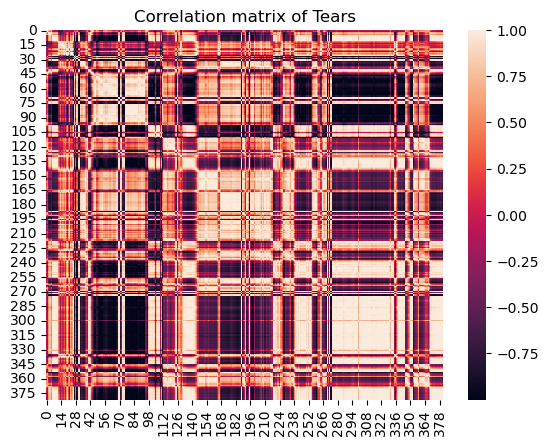

In [334]:
# plot a heatmap
import seaborn as sns

sns.heatmap(corr_tears_features)
# add a title
plt.title('Correlation matrix of Tears')
# show the plot

### Close

In [275]:
# plot the correlation matrix with plotly
import plotly.figure_factory as ff

fig = ff.create_annotated_heatmap(
    z=corr.values,
    x=list(corr.columns),
    y=list(corr.index),
    annotation_text=corr.round(2).values,
    showscale=True)

fig.update_layout(
    title_text='Correlation Matrix',
    height=800,
    width=800,
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    yaxis_autorange='reversed')

fig.show()

KeyboardInterrupt: 

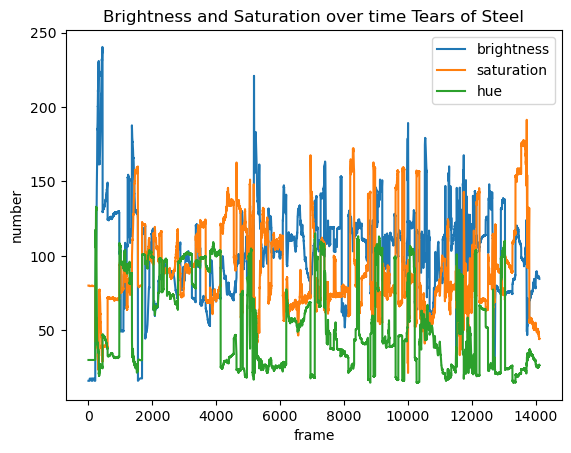

In [ ]:
# plot the line plot
plt.plot(df['frame'], df['average_brightness'], label = "brightness")
plt.plot(df['frame'], df['average_saturation'], label = "saturation")
plt.plot(df['frame'], df['average_hue'], label = "hue")
plt.xlabel('frame')
plt.ylabel('number')
plt.title('Brightness and Saturation over time Tears of Steel')
plt.legend()
plt.show()
plt.close()

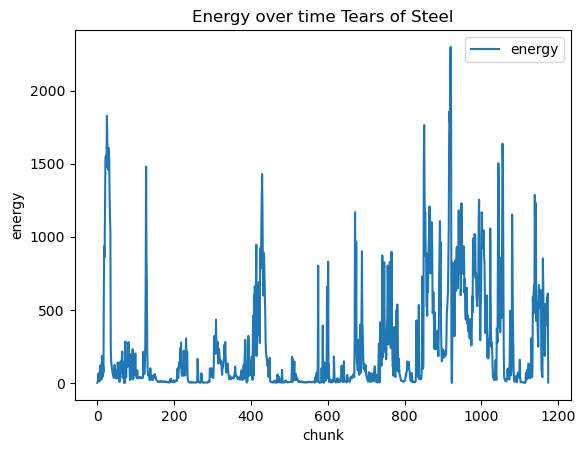

In [ ]:
# load the numpy array
s_energy = np.load('/Users/silviaromanato/Desktop/SEMESTER_PROJECT/HigherOrder/Data/Output/energy_Tears_Of_Steel_exp.mp4.npy')
# plot the line plot
plt.plot(s_energy, label = "energy")    
plt.xlabel('chunk')
plt.ylabel('energy')
plt.title('Energy over time Tears of Steel')
plt.legend()
plt.show()
plt.close()

In [ ]:
# Extract the two columns of interest
brightness = df['average_brightness']
saturation = df['average_saturation']

print(brightness.shape)

brightness = brightness.rolling(20).mean()
# drop every three rows
brightness = brightness.iloc[::20]

saturation = saturation.rolling(20).mean()
# drop every three rows
saturation = saturation.iloc[::20]

print(brightness.shape)

# make them numpy arrays
brightness = np.array(brightness)
saturation = np.array(saturation)

(14112,)
(706,)


/Users/silviaromanato/.conda/envs/silviasenv/lib/python3.9/site-packages/numpy/lib/function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/silviaromanato/.conda/envs/silviasenv/lib/python3.9/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/silviaromanato/.conda/envs/silviasenv/lib/python3.9/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


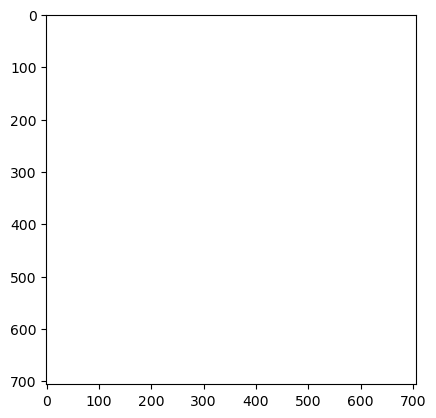

In [ ]:
# Calculate the correlation matrix
correlation_matrix = np.zeros((brightness.shape[0], brightness.shape[0]))

# Calculate the correlation between time points
for i in range(brightness.shape[0]):
    for j in range(brightness.shape[0]):
        correlation_matrix[i, j] = np.corrcoef(brightness[i], brightness[j])[0, 1]

# Plot the correlation matrix
plt.imshow(correlation_matrix, cmap='hot', interpolation='nearest')
plt.show()

In [ ]:
correlation_matrix.shape

(706, 706)

## **EMOTIONS**

In [276]:
import json
movies = ['Sintel', 'TearsOfSteel']

dict_emo = {}
for i in movies:
    print('Reading the  movie: ', i)

    # Read the data
    PATH_EMO = f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Data/EmoData/Annot13_{i}_stim.tsv'
    emo_data = pd.read_csv(PATH, sep='\t', header = None)

    PATH_COL = f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Data/EmoData/Annot13_{i}_stim.json'
    cols = pd.read_json(PATH_COL)

    emo_data.columns = cols['Columns']

    dict_emo[f'{i}'] = emo_data

dict_emo['Sintel']



Reading the  movie:  Sintel
Reading the  movie:  TearsOfSteel


Columns,Standards,PleasantSelf,SocialNorms,PleasantOther,GoalsOther,Controlled,Predictable,Suddenly,Agent,Urgency,...,Disgust,Happiness,Fear,Regard,Anxiety,Satisfaction,Pride,Surprise,Love,Sad
0,0.142779,0.280994,0.250808,0.328129,-0.341853,-0.076527,1.608599,-0.028017,-0.552002,-0.046602,...,0.096514,0.380354,-0.175466,-0.041718,-0.640479,0.108885,0.338034,-0.323917,-0.002780,-0.135239
1,0.015013,0.494457,0.249501,0.450989,-0.385761,0.149775,1.759463,-0.145929,-0.384084,-0.903029,...,0.171040,0.501055,-0.435483,-0.165635,-1.016242,0.296978,0.327484,-0.239358,-0.041027,-0.578881
2,0.111895,0.379207,0.301687,0.406774,-0.177232,0.071397,1.389785,-0.254257,-0.434333,-1.026431,...,0.190069,0.442290,-0.780270,-0.114860,-1.344420,0.218283,0.333089,-0.326162,-0.033684,-0.411382
3,0.003497,0.436321,0.348070,0.256837,0.043328,0.112072,1.395176,-0.403323,-0.411058,-1.142923,...,-0.239981,0.341601,-0.926450,-0.147157,-1.809505,0.240899,0.328852,-0.237217,-0.652728,-0.506162
4,0.047341,0.398358,0.408016,0.023101,0.050589,0.089734,-0.004557,-0.436066,-0.423261,-1.183450,...,-0.600919,-0.037521,-0.826945,-0.123036,-1.923554,0.117960,0.332433,-0.328507,-0.960898,-0.436342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,0.277206,-1.045748,0.421057,-0.269234,0.164206,-1.507128,-0.346099,-0.116964,-0.937967,1.257242,...,-0.579122,-0.324680,1.229120,0.987560,0.324021,-1.015855,0.316130,-0.244103,0.473909,2.326078
378,0.524119,-1.008374,0.444389,-0.253365,0.135938,-1.453740,-0.322617,-0.163794,-0.937614,1.206619,...,-0.548960,-0.319971,1.214208,0.766997,0.347726,-0.834010,0.313360,-0.311979,0.453638,2.426449
379,0.591231,-1.054888,0.386529,-0.363712,0.156573,-1.513146,-0.394327,0.424906,-0.927401,1.276631,...,-0.584802,-0.356155,1.232438,0.638471,0.445691,-0.931027,0.350350,-0.049155,0.401944,2.491644
380,0.513245,-1.010386,0.363760,-0.398898,0.128041,-1.439247,-0.308223,1.816059,-1.121465,1.185867,...,-0.539357,-0.324078,1.211280,0.627761,0.455619,-0.909971,0.381995,-0.299408,0.224079,2.392121


Text(0.5, 1.0, 'Correlation matrix of Tears of Steel Emotions')

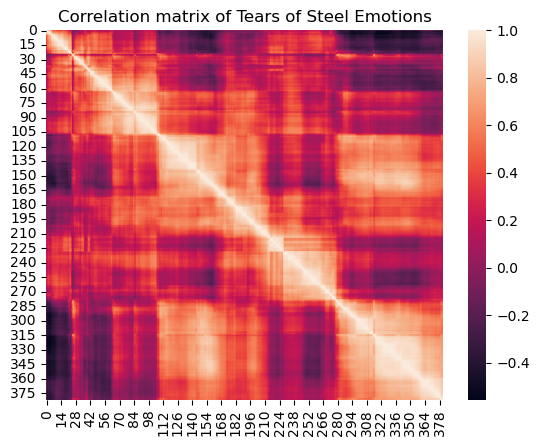

In [285]:
# compute the tempo tempo matrix

# invert the dimension of the matrix
tears_emo = dict_emo['TearsOfSteel'] 
tears_emo = tears_emo.T

# Comput the correlation matrix
corr_emo_tears = tears_emo.corr()

# plot a heatmap
import seaborn as sns

sns.heatmap(corr_emo_tears)
# add a title
plt.title('Correlation matrix of Tears of Steel Emotions')

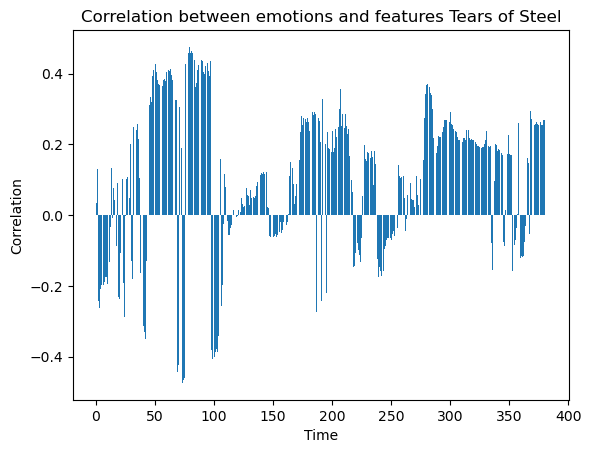

In [335]:
# compute  the correlation between corr_emo_sintel and corr_sintel_features
corr_emo_tears_features = corr_emo_tears.corrwith(corr_tears_features)

# plot a barplot
plt.bar(corr_emo_tears_features.index, corr_emo_tears_features.values)
plt.title('Correlation between emotions and features Tears of Steel')
# add the labels to the x axis "Time"
plt.xlabel('Time')
# add the labels to the y axis "Correlation"
plt.ylabel('Correlation')
plt.show()

